# Домашнее задание 6

## Провести сравнение RNN, LSTM, GRU на датасете отзывов (из предыдущих занятий/материалов)

In [1]:
!pip install stop_words

In [2]:
!pip install pymorphy2

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

Укажем значения гиперпараметров

In [4]:
max_words = 2000
max_len = 50
epochs = 40
batch_size = 2048
vec_len = 10
NUM_CLASSES = 2

In [5]:
tf.__version__

'2.3.0'

In [6]:
keras.__version__

'2.4.3'

In [7]:
import random
seed = 2020
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

**Предобработка**

In [8]:
from stop_words import get_stop_words
from string import punctuation
from pymorphy2 import MorphAnalyzer
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

Считаем данные с диска

In [9]:
data = pd.read_excel('отзывы за лето.xls')
data.shape

(20659, 3)

In [10]:
data.head(3)

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14


In [11]:
TARGET = 'target'
PROCESSED = 'preprocessed'

In [12]:
def prepare_data(df: pd.DataFrame,
                 num_classes: int,
                 processed_field: str = PROCESSED,
                 target_field: str = TARGET) -> pd.DataFrame:
    
    print(f"Подготовка данных...")
    
    df[processed_field] = df['Content'].apply(preprocess_text)
    
    if num_classes == 2:
        df = df[df['Rating'] != 3]
        df[target_field] = (df['Rating'] > 3).astype('uint8')
        
    else:
        df[target_field] = df['Rating'] - 1
    
    return df

In [13]:
def preprocess_text(txt):
    txt = str(txt)
    txt = re.sub(r'( )+', " ", re.sub(r'[^\w\s]', " ", txt)).strip()
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    txt = " ".join(txt)
    txt = re.sub("\sне", "не", txt)
    return txt

In [14]:
def get_splits(data, seed=seed):
    print(f"Выполнение сплитования...")
    
    train, test = train_test_split(data, test_size=0.6, shuffle=True, random_state=seed)
    valid, test = train_test_split(test, test_size=0.5, shuffle=True, random_state=seed)
    
    return train, valid, test

In [15]:
import regex as re
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
data = prepare_data(data, NUM_CLASSES)
df_train, df_val, df_test = get_splits(data)

text_corpus_train = df_train[PROCESSED].values
text_corpus_valid = df_val[PROCESSED].values
text_corpus_test = df_test[PROCESSED].values

tokenizer = Tokenizer(num_words=None, 
                      lower = False,
                      split = ' ')
tokenizer.fit_on_texts(text_corpus_train)

sequences_train = tokenizer.texts_to_sequences(text_corpus_train)
sequences_val = tokenizer.texts_to_sequences(text_corpus_valid)
sequences_test = tokenizer.texts_to_sequences(text_corpus_test)

word_count = len(tokenizer.index_word) + 1
training_length = max([len(i.split()) for i in text_corpus_train])

X_train = pad_sequences(sequences_train, maxlen=training_length)
X_valid = pad_sequences(sequences_val, maxlen=training_length)
X_test = pad_sequences(sequences_test, maxlen=training_length)

y_train = df_train[TARGET].values
y_val = df_val[TARGET].values
y_test = df_test[TARGET].values

Подготовка данных...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Выполнение сплитования...


In [16]:
df_train.head(3)

,Rating,Content,Date,preprocessed,target
11154,5,Мне очень нравится,2017-07-29,нравиться,1
12115,5,Отличное приложение,2017-07-27,отличный приложение,1
5771,5,Очень нравится,2017-08-05,нравиться,1


In [17]:
df_val.head(3)

,Rating,Content,Date,preprocessed,target
8003,5,Работает.,2017-08-02,работать,1
16882,5,"Ужасно, после обновления, показывает что у мен...",2017-07-15,ужасно обновление показывать рута правонету пл...,1
13810,5,Ок,2017-07-24,около,1


In [18]:
df_test.head(3)

,Rating,Content,Date,preprocessed,target
14520,1,Убрали авторизацию по отпечатку пальца.,2017-07-23,убрать авторизация отпечаток палец,0
15638,5,Все устраивает,2017-07-21,устраивать,1
7890,5,"удобно, есть антивирус встроенный",2017-08-02,удобно антивирус встроить,1


**Рассмотрим RNN**

In [19]:
def build_model(memory_cells_type: callable,
                max_words: int,
                train_len: int
               ):
    print(f"Построение модели...")

    model = Sequential()

    model.add(
        Embedding(input_dim=max_words,
                  input_length=train_len,
                  output_dim=30,
                  trainable=True,
                  mask_zero=True))
    model.add(Masking(mask_value=0.0))

    model.add(memory_cells_type(64))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    print("Готово. Резюме модели:")
    print(model.summary())
    
    return model

In [20]:
from keras.layers import SimpleRNN, Embedding, Masking, Dense, Dropout
from keras.models import Sequential
model = build_model(memory_cells_type=SimpleRNN,
                    max_words=word_count,
                    train_len=training_length)

Построение модели...
Готово. Резюме модели:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 101, 30)           155460    
_________________________________________________________________
masking (Masking)            (None, 101, 30)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                6080      
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 165,765
Trainable params: 165,765
Non-trainable params: 0
______

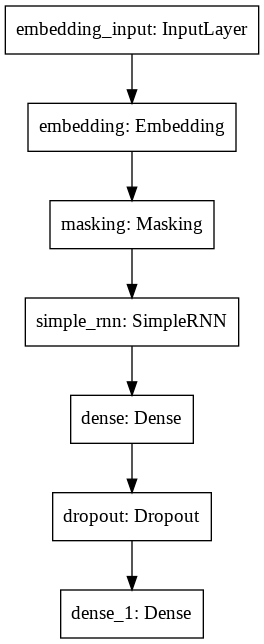

In [21]:
tf.keras.utils.plot_model(model)

In [22]:
%%time
from keras.callbacks import EarlyStopping 
early_stopping = EarlyStopping(monitor='val_loss')  

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2,
                    shuffle=True,
                    callbacks=[early_stopping])

Epoch 1/40
4/4 [==============================] - 1s 176ms/step - loss: 0.6719 - accuracy: 0.5985 - val_loss: 0.5537 - val_accuracy: 0.8563
Epoch 2/40
4/4 [==============================] - 0s 118ms/step - loss: 0.5500 - accuracy: 0.8273 - val_loss: 0.4591 - val_accuracy: 0.8563
Epoch 3/40
4/4 [==============================] - 0s 115ms/step - loss: 0.4689 - accuracy: 0.8451 - val_loss: 0.4137 - val_accuracy: 0.8563
Epoch 4/40
4/4 [==============================] - 0s 115ms/step - loss: 0.4490 - accuracy: 0.8455 - val_loss: 0.4103 - val_accuracy: 0.8563
Epoch 5/40
4/4 [==============================] - 0s 113ms/step - loss: 0.4473 - accuracy: 0.8455 - val_loss: 0.4127 - val_accuracy: 0.8563
CPU times: user 6 s, sys: 709 ms, total: 6.71 s
Wall time: 4.92 s


In [23]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\nTest score:', score[0])
print('Test accuracy:', score[1])

12/12 [==============================] - 0s 12ms/step - loss: 0.4400 - accuracy: 0.8428

Test score: 0.4400107264518738
Test accuracy: 0.842842698097229


In [24]:
%%time
from sklearn.metrics import roc_auc_score
res = model.predict(X_test)
print(f'Test score: {round(roc_auc_score(y_test, res),3)}')

Test score: 0.829
CPU times: user 2.15 s, sys: 36.9 ms, total: 2.18 s
Wall time: 2.09 s


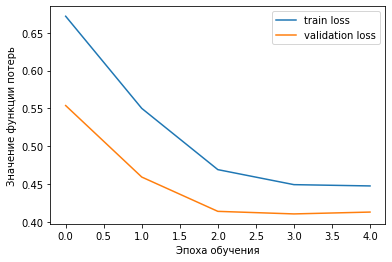

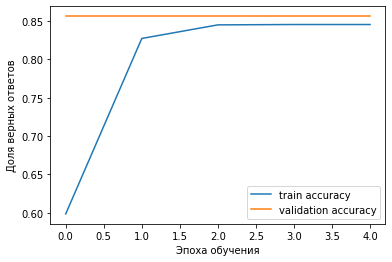

In [25]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение функции потерь')
plt.legend()

plt.figure()
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

plt.show()

**Рассмотрим LSTM**

In [26]:
from keras.layers import LSTM
model = build_model(memory_cells_type=LSTM,
                    max_words=word_count,
                    train_len=training_length)

Построение модели...
Готово. Резюме модели:
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 101, 30)           155460    
_________________________________________________________________
masking_1 (Masking)          (None, 101, 30)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24320     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 184,005
Trainable params: 184,005
Non-trainable params: 0
____

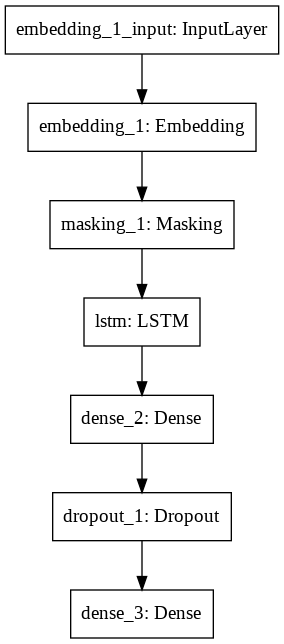

In [27]:
tf.keras.utils.plot_model(model)

In [28]:
%%time

early_stopping=EarlyStopping(monitor='val_loss')  

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2,
                    shuffle=True,
                    callbacks=[early_stopping])

Epoch 1/40
4/4 [==============================] - 1s 371ms/step - loss: 0.6879 - accuracy: 0.6636 - val_loss: 0.6679 - val_accuracy: 0.8563
Epoch 2/40
4/4 [==============================] - 0s 121ms/step - loss: 0.6606 - accuracy: 0.8455 - val_loss: 0.6264 - val_accuracy: 0.8563
Epoch 3/40
4/4 [==============================] - 0s 122ms/step - loss: 0.6102 - accuracy: 0.8455 - val_loss: 0.5213 - val_accuracy: 0.8563
Epoch 4/40
4/4 [==============================] - 0s 123ms/step - loss: 0.4837 - accuracy: 0.8455 - val_loss: 0.3960 - val_accuracy: 0.8563
Epoch 5/40
4/4 [==============================] - 0s 121ms/step - loss: 0.4410 - accuracy: 0.8455 - val_loss: 0.4040 - val_accuracy: 0.8563
CPU times: user 6.27 s, sys: 808 ms, total: 7.08 s
Wall time: 9.71 s


In [29]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\nTest score:', score[0])
print('Test accuracy:', score[1])

12/12 [==============================] - 0s 9ms/step - loss: 0.4355 - accuracy: 0.8428

Test score: 0.43552374839782715
Test accuracy: 0.842842698097229


In [30]:
%%time

res = model.predict(X_test)
print(f'Test score: {round(roc_auc_score(y_test, res),3)}')

Test score: 0.892
CPU times: user 1.66 s, sys: 96.2 ms, total: 1.75 s
Wall time: 1.56 s


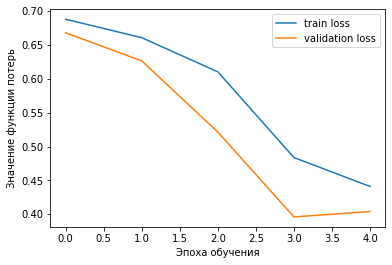

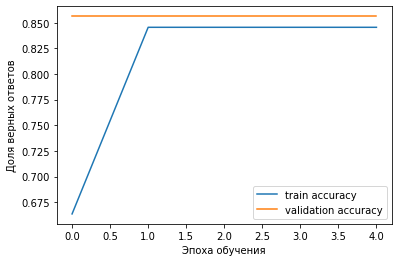

In [31]:
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение функции потерь')
plt.legend()

plt.figure()
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

plt.show()

**Рассмотрим GRU**

In [32]:
from keras.layers import GRU
model = build_model(memory_cells_type=GRU,
                    max_words=word_count,
                    train_len=training_length)

Построение модели...
Готово. Резюме модели:
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 101, 30)           155460    
_________________________________________________________________
masking_2 (Masking)          (None, 101, 30)           0         
_________________________________________________________________
gru (GRU)                    (None, 64)                18432     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 178,117
Trainable params: 178,117
Non-trainable params: 0
____

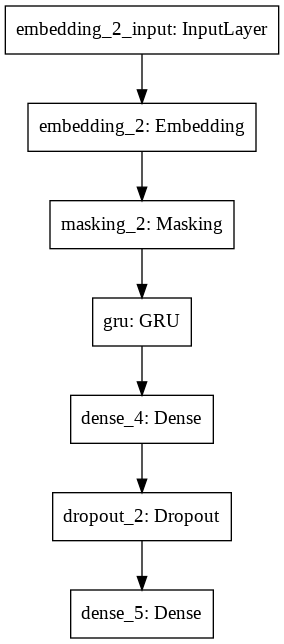

In [33]:
tf.keras.utils.plot_model(model)

In [34]:
%%time

early_stopping=EarlyStopping(monitor='val_loss')  

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2,
                    shuffle=True,
                    callbacks=[early_stopping])

Epoch 1/40
4/4 [==============================] - 1s 360ms/step - loss: 0.6878 - accuracy: 0.6778 - val_loss: 0.6663 - val_accuracy: 0.8563
Epoch 2/40
4/4 [==============================] - 0s 120ms/step - loss: 0.6576 - accuracy: 0.8455 - val_loss: 0.6256 - val_accuracy: 0.8563
Epoch 3/40
4/4 [==============================] - 0s 122ms/step - loss: 0.6142 - accuracy: 0.8455 - val_loss: 0.5644 - val_accuracy: 0.8563
Epoch 4/40
4/4 [==============================] - 0s 121ms/step - loss: 0.5471 - accuracy: 0.8455 - val_loss: 0.4715 - val_accuracy: 0.8563
Epoch 5/40
4/4 [==============================] - 0s 121ms/step - loss: 0.4526 - accuracy: 0.8455 - val_loss: 0.3597 - val_accuracy: 0.8563
Epoch 6/40
4/4 [==============================] - 0s 120ms/step - loss: 0.3783 - accuracy: 0.8455 - val_loss: 0.3707 - val_accuracy: 0.8563
CPU times: user 5.1 s, sys: 329 ms, total: 5.43 s
Wall time: 8.45 s


In [35]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\nTest score:', score[0])
print('Test accuracy:', score[1])

12/12 [==============================] - 0s 8ms/step - loss: 0.4111 - accuracy: 0.8428

Test score: 0.41110867261886597
Test accuracy: 0.842842698097229


In [36]:
%%time 
res = model.predict(X_test)
print(f'Test score: {round(roc_auc_score(y_test, res),3)}')

Test score: 0.898
CPU times: user 1.94 s, sys: 98.5 ms, total: 2.04 s
Wall time: 1.87 s


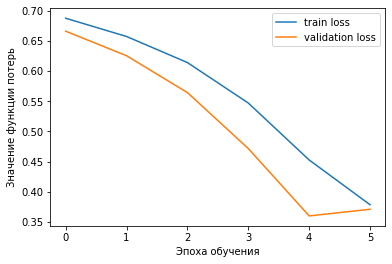

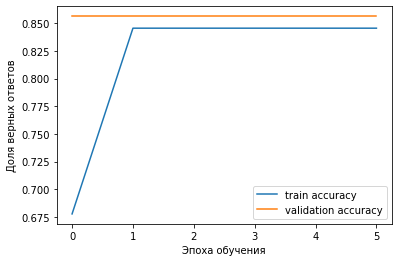

In [37]:
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение функции потерь')
plt.legend()

plt.figure()
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

plt.show()

**Вывод:** наибольший тест скор был получен на GRU